In [1]:
import os
import glob

import librosa
import torchaudio
import soundfile as sf

from src.data.util import log_compress

In [2]:
# Gather all the flac and json
data_dir = "./LibriLight/small"

def gather_flac_json_pairs(root_dir):
    flac_files = glob.glob(os.path.join(root_dir, '**', '*.flac'), recursive=True)
    pairs = []

    for flac_path in flac_files:
        json_path = os.path.splitext(flac_path)[0] + '.json'
        if os.path.exists(json_path):
            pairs.append((flac_path, json_path))
        else:
            print(f"Warning: No JSON companion for {flac_path}")

    return pairs

pairs = gather_flac_json_pairs(data_dir)

In [27]:
# Verify Sampling rate
def get_sample_rate(path):
    metadata = sf.info(path)
    return metadata.samplerate

sample_rate = {}
for path, _ in pairs:
    info = f'{get_sample_rate(path)} hz'
    if info not in sample_rate:
        sample_rate[info] = 1
    else:
        sample_rate[info] += 1
print(sample_rate)

{'16000 hz': 2588}


[(3.04, 1600), (3.36, 1586), (2.88, 1582), (3.28, 1577), (3.2, 1560), (2.4, 1558), (3.52, 1549), (3.44, 1539), (3.6, 1535), (3.68, 1520)]
min: 0.5599999999994907
max: 1120.4


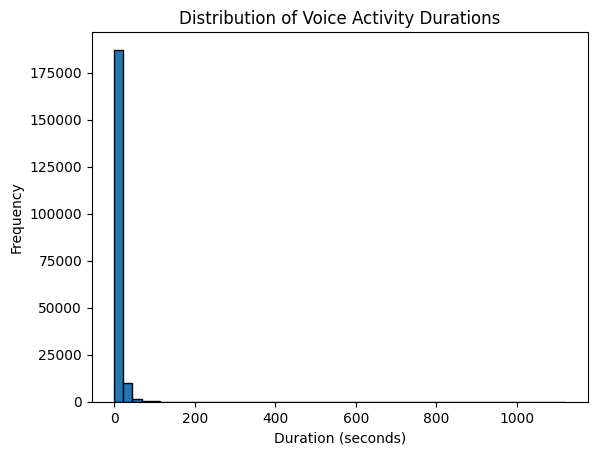

In [34]:
# Distribution of Voice Activity block length.
# Specific to LibriLight
from collections import Counter
import json
from pathlib import Path
import matplotlib.pyplot as plt

def collect_duration_differences(flac_json_pairs):
    all_durations = []

    for flac_path, json_path in flac_json_pairs:
        with open(json_path, 'r') as f:
            data = json.load(f)

        voice_activity = data.get('voice_activity', [])
        durations = [end - start for start, end in voice_activity]
        all_durations.extend(durations)

    return all_durations

def plot_duration_distribution(durations, bins=50):
    plt.hist(durations, bins=bins, edgecolor='black')
    plt.title('Distribution of Voice Activity Durations')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    plt.show()

def top_n_durations(durations, n=10, rounding=2):
    rounded_durations = [round(d, rounding) for d in durations]
    counter = Counter(rounded_durations)
    most_common = counter.most_common(n)
    return most_common


durations = collect_duration_differences(pairs)
print(top_n_durations(durations))
print('min: ' + str(min(durations)))
print('max: ' + str(max(durations)))
plot_duration_distribution(durations)

[(0.96, 239), (1.04, 227), (0.88, 221), (1.68, 219), (0.8, 219), (1.6, 202), (1.84, 201), (1.76, 198), (1.92, 196), (1.52, 196)]
min: 0.5599999999994907
max: 4076.48


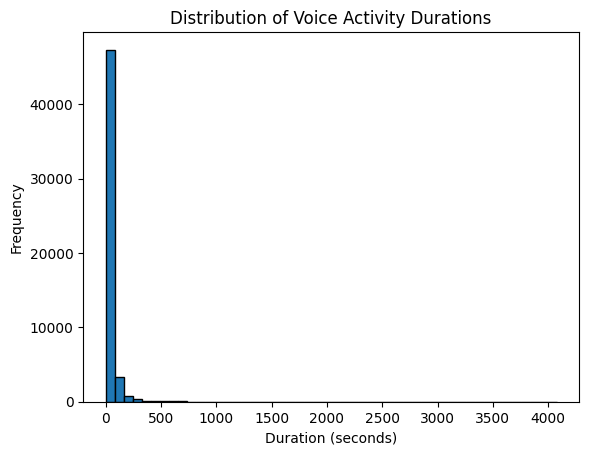

In [35]:
# What if we allow for silence of 1s

def merge_close_blocks(voice_activity, threshold=1.0):
    if not voice_activity:
        return []

    # Sort by start time just in case
    voice_activity = sorted(voice_activity, key=lambda x: x[0])
    merged = [voice_activity[0]]

    for start, end in voice_activity[1:]:
        last_start, last_end = merged[-1]
        if start - last_end < threshold:
            # Merge intervals
            merged[-1][1] = max(last_end, end)
        else:
            merged.append([start, end])

    return merged

def get_duration_diff_merged(pairs):
    all_durations = []

    for flac_path, json_path in pairs:
        with open(json_path, 'r') as f:
            data = json.load(f)

        voice_activity = data.get('voice_activity', [])
        voice_activity = merge_close_blocks(voice_activity)
        durations = [end - start for start, end in voice_activity]
        all_durations.extend(durations)

    return all_durations

durations = get_duration_diff_merged(pairs)
print(top_n_durations(durations))
print('min: ' + str(min(durations)))
print('max: ' + str(max(durations)))
plot_duration_distribution(durations)

In [37]:
import torch
a = torch.tensor([[1,2],
                  [3,4]])
b = torch.tensor([[5,6],
                 [7,8]])
torch.maximum(a, a.max() - 1)

tensor([[3, 3],
        [3, 4]])

In [10]:
from torchaudio import transforms
import torchaudio

test_flac = '/Users/lkieu/PycharmProjects/PhonemeAwareFoundational/test_audio/canterburytales_09_chaucer_64kb.flac'
waveform, sample_rate = torchaudio.load(test_flac, normalize=True)
transform = transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=1024, hop_length=256, n_mels=80)
melspec = transform(waveform)
# Define max size (in time frames)
max_frames = 500  # Example

def crop_or_pad(spec, max_frames):
    channels, n_mels, time_frames = spec.shape
    if time_frames > max_frames:
        return spec[:, :, :max_frames]
    elif time_frames < max_frames:
        pad_amount = max_frames - time_frames
        pad = torch.zeros((channels, n_mels, pad_amount), device=spec.device)
        return torch.cat((spec, pad), dim=2)
    else:
        return spec

melspec= crop_or_pad(melspec, max_frames)
print(melspec.shape)  # Should be (channels, n_mels, max_frames)


torch.Size([1, 80, 500])


In [18]:
from src.data.util import log_compress
import librosa

log_spec_lib = librosa.power_to_db(melspec[0])
log_spec_torch = log_compress(melspec[0])

In [19]:
import matplotlib.pyplot as plt

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

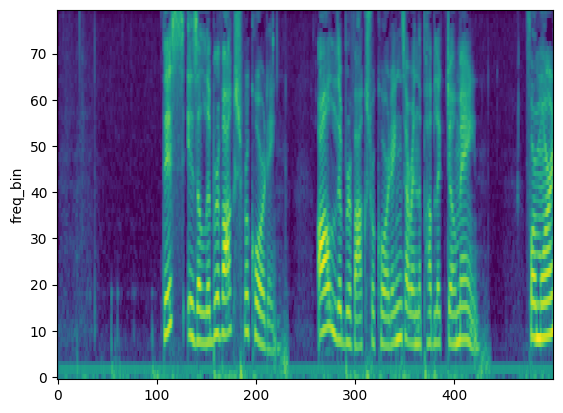

In [20]:
plot_spectrogram(log_spec_lib)

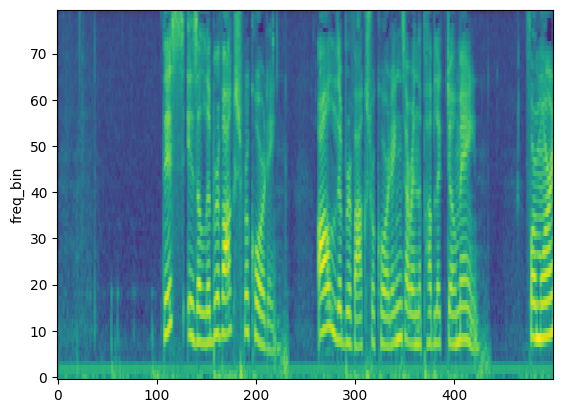

In [21]:
plot_spectrogram(log_spec_torch)

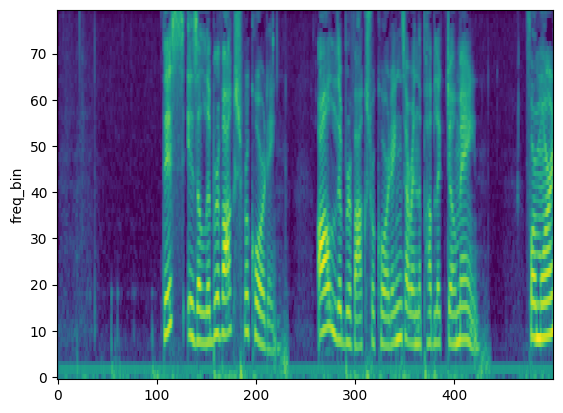

In [22]:
from src.data.util import whisper_norm, z_score_norm, min_max_norm
whisper_norm_log_spec = whisper_norm(log_spec_torch)
plot_spectrogram(whisper_norm_log_spec)

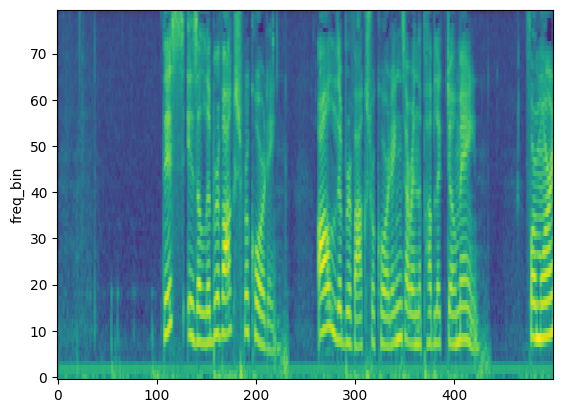

In [23]:
z_norm = z_score_norm(log_spec_torch)
plot_spectrogram(z_norm)

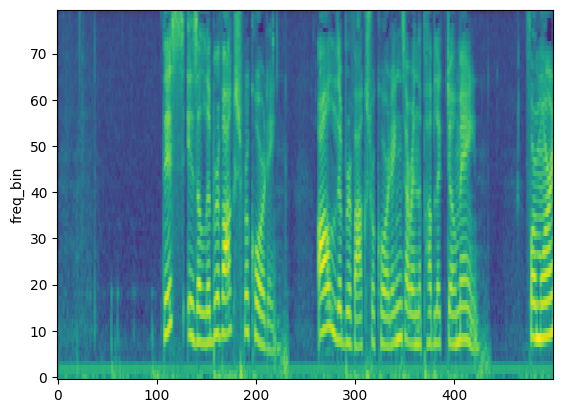

In [24]:
min_max_norm_log_spec = min_max_norm(log_spec_torch)
plot_spectrogram(min_max_norm_log_spec)